In [1]:
pip install -q torch torchvision torchaudio librosa av opencv-python Pillow tqdm numpy pandas scikit-learn pytorchvideo transformers datasets evaluate peft

Note: you may need to restart the kernel to use updated packages.


# Additional Modules.py

In [2]:
import torch
import torch.nn as nn
import math

class Gate_Attention(nn.Module):
    def __init__(self, num_hidden_a, num_hidden_b, num_hidden):
        super(Gate_Attention, self).__init__()
        self.hidden = num_hidden
        self.w1 = nn.Parameter(torch.Tensor(num_hidden_a, num_hidden))
        self.w2 = nn.Parameter(torch.Tensor(num_hidden_b, num_hidden))
        self.bias = nn.Parameter(torch.Tensor(num_hidden))
        self.reset_parameter()

    def reset_parameter(self):
        stdv1 = 1. / math.sqrt(self.hidden)
        stdv2 = 1. / math.sqrt(self.hidden)
        stdv = (stdv1 + stdv2) / 2.
        self.w1.data.uniform_(-stdv1, stdv1)
        self.w2.data.uniform_(-stdv2, stdv2)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, a, b):
        wa = torch.matmul(a, self.w1)
        wb = torch.matmul(b, self.w2)
        gated = wa + wb + self.bias
        gate = torch.sigmoid(gated)
        output = gate * a + (1 - gate) * b
        return output  # Clone the tensor to make it out of place operation
    
class LSTM_fc(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_seq_len, output_size):
        super(LSTM_fc, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq_len = output_seq_len
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*hidden_size, out_features=output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))

        
        
        output = self.fc(out[:, :self.output_seq_len, :])

        return output
    
    
class Conv1d_fc(nn.Module):
    def __init__(self, encoder_embed_dim , llm_embed_dim, kernel_size, stride, padding):
        super(Conv1d_fc, self).__init__()
        
        #input_channels, output_channels - embedding dim of encoder
        # conv on seq_len
        
        self.conv1d = nn.Conv1d(in_channels=encoder_embed_dim, out_channels=encoder_embed_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        self.fc = nn.Linear(in_features=encoder_embed_dim, out_features=llm_embed_dim)

    def forward(self, x):
        
        x = self.conv1d(x.transpose(1,2).contiguous()).transpose(1,2).contiguous()
        output = self.fc(x)
        
        return output

    
class FC_head(nn.Module):
    def __init__(self, num_classes, hidden_dim, llm_embed_dim, add_pooling = False):
        super(FC_head, self).__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.llm_embed_dim = llm_embed_dim
        self.add_pooling = add_pooling
        
        self.pooling = nn.Linear(in_features=llm_embed_dim, out_features=llm_embed_dim)
        self.activation = nn.Tanh()
        
        self.fc1 = nn.Linear(in_features=llm_embed_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)
        
    def forward(self, x):
        if self.add_pooling:
            x = self.pooling(x)
            x = self.activation(x)
        
        x = torch.mean(x, dim=1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
        
        
        
        
        
        
    

# Utils.py

In [3]:
import av
import numpy as np
import os
from transformers import AutoImageProcessor, CLIPProcessor, AutoFeatureExtractor, WhisperFeatureExtractor
import cv2
import random
import torch

np.random.seed(0)

max_length = 50000
max_len = 64

audio_processor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
video_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def get_actual_seg_len(container):
    length = 0
    for i, frame in enumerate(container.decode(video=0)):
        length+=1
    return length
    
    
def read_video_pyav(container, indices, clip_len, seg_len):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    if seg_len > clip_len:
        container.seek(0)
        start_index = indices[0]
        end_index = indices[-1]
        for i, frame in enumerate(container.decode(video=0)):
            if i > end_index:
                break
            if i >= start_index and i in indices:
                frames.append(frame)
    else:
        container.seek(0)
        start_index = indices[0]
        end_index = indices[-1]
        
        start_frame = 0
                
        for i, frame in enumerate(container.decode(video=0)):
            if i > end_index:
                break
            if i >= start_index and i in indices:
                frames.append(frame)
                if i == 0:
                    start_frame = frame
        
        init_frames = [start_frame]*(clip_len-seg_len)
        init_frames.extend(frames)
        frames = init_frames
       
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    
    if seg_len > clip_len: 
        converted_len = int(clip_len * frame_sample_rate)

        # Ensure the chosen segment is valid
        start_idx = np.random.randint(low=0, high=seg_len - converted_len + 1)
        end_idx = start_idx + converted_len

        # Generate equally spaced indices within the chosen segment
        indices = np.linspace(start_idx, end_idx - 1, num=clip_len, dtype=np.int64)
    
    else:
        indices_start = [0]*(clip_len-seg_len)
        indices = range(seg_len)
        indices_start.extend(indices)
        indices = np.array(indices_start, dtype=np.int64)
    
    # print(indices.shape)
    return indices

def read_random_jpg(directory_path):
    jpg_files = [file for file in os.listdir(directory_path) if file.endswith('.jpg')]

    if not jpg_files:
        raise FileNotFoundError("No '.jpg' files found in the specified directory.")

    selected_file = random.choice(jpg_files)
    file_path = os.path.join(directory_path, selected_file)

    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

    return image 

def return_video_tensor(file_path, clip_len=16, frame_sample_rate=5):
    container = av.open(file_path)
    
    # seg_len=container.streams.video[0].frames
    seg_len = get_actual_seg_len(container)
    frame_sample_rate_calculated=int(seg_len/clip_len)
    if frame_sample_rate_calculated < frame_sample_rate:
        frame_sample_rate=frame_sample_rate_calculated-1
    if not frame_sample_rate:
        frame_sample_rate=1
    indices = sample_frame_indices(clip_len=clip_len, frame_sample_rate=frame_sample_rate, seg_len=seg_len)
    video = read_video_pyav(container, indices, clip_len, seg_len)
    inputs = video_processor(list(video), return_tensors="pt")
    inputs = inputs["pixel_values"] #shape - [1, 16, 3, 224, 224]
    
    # if(inputs.shape[1] != 16):
        # print(indices, frame_sample_rate, seg_len, inputs.shape[1])
    return inputs.squeeze(dim=0).cpu()


def return_image_tensor(directory_path):
    image = read_random_jpg(directory_path=directory_path)
    inputs = image_processor(images = image, return_tensors="pt")
    inputs = inputs["pixel_values"]  #shape - [1, 3, 224, 224]
    return inputs.squeeze(dim=0).cpu()

def return_audio_tensor(file_path):
    input_audio = np.load(file_path)
    input_audio = audio_processor(input_audio, sampling_rate=16000, return_tensors="pt")
    input_features = input_audio["input_features"]
    return input_features.squeeze(dim=0).cpu()

def prepare_batch(batch, tokenizer):
    dialogue = batch["dialogue"]
    tokenized_text = tokenizer(dialogue, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len-3, add_special_tokens=False)
    token_type_ids = torch.ones_like(tokenized_text.input_ids)
    
    new_batch = {  
        'abusive': batch['abusive'],
        # 'video': batch['video'],
        'audio': batch['audio'],
        'input_ids': tokenized_text.input_ids.squeeze(dim=0),
        'attention_mask': tokenized_text.attention_mask.squeeze(dim=0),
        'token_type_ids': token_type_ids.squeeze(dim=0),
    }
    
    return new_batch

2025-01-20 10:08:45.576130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 10:08:45.576320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 10:08:45.717137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

# Data

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import random
import torchaudio
import pytorchvideo.data
from ast import literal_eval
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)
from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    CenterCrop,
    Normalize,
    RandomRotation,
)
            

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, train):
        self.dataframe = dataframe
        self.train = train
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        dialogue = self.dataframe["text"].iloc[idx]
        abusive_labels = torch.tensor(literal_eval(self.dataframe["abusive"].iloc[idx]), device="cpu")
        audio = self.dataframe['audio_path'].iloc[idx]
        
        audio = return_audio_tensor(audio)

        sample = {
            'dialogue': dialogue,
            'abusive': abusive_labels,
            'audio': audio,
        }
        
        sample = prepare_batch(batch=sample, tokenizer=self.tokenizer)
        return sample


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


# Model.py

In [5]:
import torch
import torch.nn as nn
from tokenizers import AddedToken
from transformers import CLIPModel, VideoMAEModel, Wav2Vec2Model, VideoMAEConfig, CLIPConfig, Wav2Vec2Config, ViTModel, WhisperModel
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSeq2SeqLM
# from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from argparse import Namespace 
from torch.utils.data import DataLoader
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AlbertTokenizer, XLMRobertaTokenizerFast, GPT2Tokenizer #only for gpt2 and assign values
from transformers import GPT2Model, BertModel, AlbertModel, XLMRobertaModel
# Model Architecture

class Multimodal_LLM(nn.Module):
    def __init__(self, batch_size, config, tokenizer, adapter_llm):
        super(Multimodal_LLM, self).__init__()
        
        self.config = config
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.tokenizer.padding_side = "right"
        
        self.output_seq_len = min(self.config.audio_seq_len, self.config.min_mm_seq_len)
        
        # Audio encoder only
        self.audio_encoder = WhisperModel.from_pretrained(config.audio_encoder).encoder
        self.adapter_llm = adapter_llm
        
        # Transform layer for audio
        if self.config.lstm_or_conv:
            self.transform_audio_to_hidden = LSTM_fc(
                input_size=self.config.audio_dim, 
                hidden_size=self.config.audio_dim,
                num_layers=self.config.lstm_num_layers, 
                output_seq_len=self.output_seq_len, 
                output_size=self.config.llm_embed_dim
            )
        else:
            self.transform_audio_to_hidden = Conv1d_fc(
                encoder_embed_dim=self.config.audio_dim, 
                llm_embed_dim=self.config.llm_embed_dim,
                kernel_size=self.config.audio_conv_kernel, 
                stride=self.config.audio_conv_stride, 
                padding=self.config.audio_conv_padding
            )
        
        # Audio attention only
        self.audio_align_attention = nn.MultiheadAttention(
            self.config.llm_embed_dim,
            self.config.attention_heads * 2,
            dropout=self.config.attn_dropout,
            add_bias_kv=self.config.is_add_bias_kv,
            add_zero_attn=self.config.is_add_zero_attn
        )
        
        self.abusive_head = FC_head(
            num_classes=5, 
            hidden_dim=64, 
            llm_embed_dim=self.config.llm_output_dim, 
            add_pooling=self.config.add_pooling
        )

        self.criterion_abusive = nn.CrossEntropyLoss()
        
    def forward(self, inputs):
        batch_size = inputs["abusive"].shape[0]
        
        # Token handling
        bos = torch.ones([batch_size, 1], dtype=torch.int64, device=self.config.device) * self.tokenizer.bos_token_id
        sep = torch.ones([batch_size, 1], dtype=torch.int64, device=self.config.device) * self.tokenizer.eos_token_id
        eos = torch.ones([batch_size, 1], dtype=torch.int64, device=self.config.device) * self.tokenizer.eos_token_id

        # Mask handling
        attention_mask_bos = torch.ones([batch_size, 1], dtype=torch.int64, device=self.config.device)
        attention_mask_multimodal = torch.ones([batch_size, self.output_seq_len+1], dtype=torch.int64, device=self.config.device)
        attention_mask_eos = torch.zeros([batch_size, 1], dtype=torch.int64, device=self.config.device)
        
        # Type IDs
        token_type_ids_bos = torch.zeros([batch_size, 1], dtype=torch.int64, device=self.config.device)
        token_type_ids_multimodal = torch.zeros([batch_size, self.output_seq_len+1], dtype=torch.int64, device=self.config.device)
        token_type_ids_eos = torch.ones([batch_size, 1], dtype=torch.int64, device=self.config.device)
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        # For Electra embeddings
        embed_tokens = self.adapter_llm.get_input_embeddings()
        token_embeddings = embed_tokens.weight.unsqueeze(0).repeat(batch_size, 1, 1).transpose(0, 1).contiguous()
        text_embeds = embed_tokens(input_ids)
        
        # Audio processing
        audio_encoder_out = self.audio_encoder(inputs["audio"])
        audio_encoder_out = self.transform_audio_to_hidden(audio_encoder_out.last_hidden_state)
        audio_encoder_out = self.audio_align_attention(
            audio_encoder_out.transpose(0, 1).contiguous(), 
            token_embeddings,
            token_embeddings
        )[0].transpose(0, 1).contiguous()
        
        # For Electra
        bos_embeds = self.adapter_llm.get_input_embeddings()(bos)
        sep_embeds = self.adapter_llm.get_input_embeddings()(sep)
        eos_embeds = self.adapter_llm.get_input_embeddings()(eos)
        
        # Combine embeddings
        text_embeds = torch.cat([bos_embeds, audio_encoder_out, sep_embeds, text_embeds, eos_embeds], dim=1)
        
        attention_mask = torch.cat([attention_mask_bos, attention_mask_multimodal, attention_mask, attention_mask_eos], dim=1)
        token_type_ids = torch.cat([token_type_ids_bos, token_type_ids_multimodal, token_type_ids, token_type_ids_eos], dim=1)
        
        # Get LLM outputs
        llm_outputs = self.adapter_llm(
            inputs_embeds=text_embeds, 
            attention_mask=attention_mask
        ).last_hidden_state
        
        outputs = {}
                
        if self.config.abusive_bool:
            abusive_logits = self.abusive_head(llm_outputs)
            outputs["abusive"] = abusive_logits
            outputs["loss"] = self.criterion_abusive(abusive_logits, inputs["abusive"])
                                    
        return outputs



# Iteration.py

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import json
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_one_epoch(model, train_dataloader, optimizer, config, devices=None):
    model = model.to(config.device)
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader):
        batch = {key: value.to(config.device) for key, value in batch.items()}
 
        optimizer.zero_grad()
        outputs = model(batch)
        loss = outputs["loss"]
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        total_loss += loss.item()
        

    average_loss = total_loss / len(train_dataloader)
    
    return average_loss
    

def validate(model, val_dataloader, config, devices=None):
    model = model.to(config.device)
    model.eval()
    task_metrics = {task: {"accuracy": 0.0, "f1": 0.0} for task in config.tasks}
    all_labels = {task: [] for task in config.tasks}
    all_predictions = {task: [] for task in config.tasks}

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs = {key: value.to(config.device) for key, value in batch.items()}
            
            outputs = model(inputs)

            for task in config.tasks:
                # print(outputs[task], batch[task])

                task_predictions = torch.argmax(outputs[task], dim=1).detach().cpu().numpy()
                task_labels = torch.argmax(batch[task], dim=1).detach().cpu().numpy()

                task_accuracy = accuracy_score(task_labels, task_predictions)
                task_f1 = f1_score(task_labels, task_predictions, average="weighted")

                task_metrics[task]["accuracy"] += task_accuracy
                task_metrics[task]["f1"] += task_f1

                all_labels[task].extend(task_labels)
                all_predictions[task].extend(task_predictions)

    for task in config.tasks:
        task_metrics[task]["accuracy"] /= len(val_dataloader)
        task_metrics[task]["f1"] /= len(val_dataloader)
        task_metrics[task]["classification_report"] = classification_report(all_labels[task], all_predictions[task])
        print(task, " \n" , task_metrics[task]["accuracy"] , " \n", task_metrics[task]["f1"], " \n", task_metrics[task]["classification_report"], "\n")
        
    return task_metrics, all_labels, all_predictions

def train_model(model, train_dataloader, val_dataloader, config, num_epochs, track_task, track_metric, devices=None):
    
    model = model.to(config.device)
    history = {"train_validation": []}
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    best_val_metric = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} out of {num_epochs}")

        # Training
        train_loss = train_one_epoch(model, train_dataloader, optimizer, config)
        
        print(train_loss)

        # Validation
        val_metrics, _, _ = validate(model, val_dataloader, config)
        
        # print(val_metrics)

        # Save metrics to history
        epoch_data = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_metrics": val_metrics
        }
        
        history["train_validation"].append(epoch_data)
        
        json_save_path = "./results" + config.file_name + ".json"

        # Save to JSON file
        with open(json_save_path, 'w') as json_file:
            json.dump(history, json_file)
        
        
        if val_metrics[track_task][track_metric] > best_val_metric:
            best_val_metric = val_metrics[track_task][track_metric]
            torch.save(model.state_dict(),"./model_save.pth")

    
    print("Training finished!")



# Train.py

In [7]:
'''
python -W ignore run.py
python block_core.py
find -type d -name 'pymp*' -exec rm -r {} \;
'''

import torch
import torch.nn as nn
from tokenizers import AddedToken
from transformers import CLIPModel, VideoMAEModel, Wav2Vec2Model, VideoMAEConfig, CLIPConfig, Wav2Vec2Config, XLMRobertaConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSeq2SeqLM
# from model.additional_modules import LSTM_fc, FC_head, Gate_Attention
from argparse import Namespace 
# from model.model import Multimodal_LLM
# from data.dataset import CustomDataset
# from iteration import train_model, train_one_epoch, validate
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AlbertTokenizer, XLMRobertaTokenizerFast, GPT2Tokenizer
#only for gpt2 and assign values
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

from transformers import GPT2Model, BertModel, AlbertModel, XLMRobertaModel
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import os

tasks_bool = {"abusive" : True}
tasks = []
name = "gpt2_vidmae_whisper_"

for k, v in tasks_bool.items():
    if tasks_bool[k]:
        tasks.append(k)
        name += k + "_"
        
config = Namespace(
    file_name=name + "0",
    device=torch.device("cuda:0"),
    tokenizer_path="ckpts",
    tasks = tasks,
    abusive_bool = tasks_bool["abusive"],
#     abusive_level_bool = tasks_bool["abusive_level"],
#     sentiment_bool = tasks_bool["sentiment"],
    video_encoder="MCG-NJU/videomae-base",
    audio_encoder="openai/whisper-small",
    lstm_or_conv = False,
    image_conv_kernel=23,
    image_conv_stride=3,
    image_conv_padding=8,
    video_conv_kernel=36,
    video_conv_stride=24,
    video_conv_padding=0,
    audio_conv_kernel=50,
    audio_conv_stride=23,
    audio_conv_padding=1,
    llm_embed_dim=768,
    llm_output_dim=768,
    attn_dropout=0.1,
    is_add_bias_kv=True,
    is_add_zero_attn=True,
    attention_heads=8,
    image_dim=768,
    video_dim=768,
    audio_dim=768,
    image_seq_len=197,
    video_seq_len=1568,
    audio_seq_len=1500,
    min_mm_seq_len=64,
    lstm_num_layers=1,
    tokenizer_max_len=128,
    add_pooling = False,
    train=True,
    directory = "./",
    results_directory = "./results/"
)

df = pd.read_csv("/kaggle/input/hs-telugu-ohe/data.csv")
df_train_val, df_test = train_test_split(df,stratify=df['abusive'], test_size=0.1, random_state=28703)
df_train, df_val = train_test_split(df_train_val,stratify=df_train_val['abusive'], test_size=0.1, random_state=28703)

num_epochs = 10
patience = 2
batch_size = 4

# #for roberta
# tokenizer = XLMRobertaTokenizerFast.from_pretrained("l3cube-pune/hing-roberta")
# model = XLMRobertaModel.from_pretrained("l3cube-pune/hing-roberta", torch_dtype=torch.float32)

#for gpt2
# tokenizer = AutoTokenizer.from_pretrained('ritog/bangla-gpt2')
# model = GPT2Model.from_pretrained('ritog/bangla-gpt2', torch_dtype=torch.float32)
from transformers import AutoTokenizer, AutoModelForPreTraining

# tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
# model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert")
from transformers import ElectraTokenizer, ElectraModel

# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("kuppuluri/telugu_bertu")
model = AutoModel.from_pretrained("kuppuluri/telugu_bertu")

# tokenizer = ElectraTokenizer.from_pretrained("l3cube-pune/telugu-bert-scratch")
# model = ElectraModel.from_pretrained("l3cube-pune/telugu-bert-scratch")

tokenizer.bos_token_id = 1
tokenizer.eos_token_id = 2


model = Multimodal_LLM(batch_size=batch_size, config=config, tokenizer=tokenizer, adapter_llm=model)

train_ds = CustomDataset(dataframe=df_train, train=True, tokenizer=tokenizer)
val_ds = CustomDataset(df_val, train=True, tokenizer=tokenizer)
test_ds = CustomDataset(df_test, train=False, tokenizer=tokenizer)


train_dataloader = DataLoader(train_ds, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, num_workers=16)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=16)


train_model(model, train_dataloader, val_dataloader, config, num_epochs, "abusive", "f1", devices=None)

tokenizer_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/604k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at kuppuluri/telugu_bertu and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Epoch 1 out of 10


100%|██████████| 112/112 [02:16<00:00,  1.22s/it]


1.5252455393118518


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


abusive  
 0.4807692307692308  
 0.4025641025641026  
               precision    recall  f1-score   support

           0       0.48      0.91      0.62        11
           1       0.00      0.00      0.00         9
           2       0.48      0.78      0.60        18
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7

    accuracy                           0.48        50
   macro avg       0.19      0.34      0.24        50
weighted avg       0.28      0.48      0.35        50
 

Epoch 2 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


1.1448855972183603


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


abusive  
 0.5769230769230769  
 0.5371794871794872  
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       0.40      0.22      0.29         9
           2       0.58      0.78      0.67        18
           3       1.00      0.40      0.57         5
           4       0.00      0.00      0.00         7

    accuracy                           0.58        50
   macro avg       0.52      0.48      0.46        50
weighted avg       0.52      0.58      0.52        50
 

Epoch 3 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


0.9108063387684524


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


abusive  
 0.6538461538461539  
 0.6333333333333334  
               precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.54      0.78      0.64         9
           2       0.59      0.89      0.71        18
           3       1.00      0.20      0.33         5
           4       1.00      0.14      0.25         7

    accuracy                           0.66        50
   macro avg       0.83      0.55      0.55        50
weighted avg       0.77      0.66      0.62        50
 

Epoch 4 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


0.5650597192746188


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


abusive  
 0.7307692307692307  
 0.7102564102564103  
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.67      0.67      0.67         9
           2       0.62      0.89      0.73        18
           3       1.00      0.40      0.57         5
           4       0.75      0.43      0.55         7

    accuracy                           0.72        50
   macro avg       0.81      0.64      0.68        50
weighted avg       0.77      0.72      0.71        50
 

Epoch 5 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


0.35293653584916945


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


abusive  
 0.6538461538461539  
 0.6314102564102565  
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.57      0.44      0.50         9
           2       0.75      0.67      0.71        18
           3       1.00      0.80      0.89         5
           4       0.67      0.29      0.40         7

    accuracy                           0.66        50
   macro avg       0.71      0.64      0.64        50
weighted avg       0.69      0.66      0.65        50
 

Epoch 6 out of 10


100%|██████████| 112/112 [02:15<00:00,  1.21s/it]


0.16577707360764699


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


abusive  
 0.7307692307692307  
 0.726923076923077  
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.80      0.44      0.57         9
           2       0.72      0.72      0.72        18
           3       0.56      1.00      0.71         5
           4       0.67      0.57      0.62         7

    accuracy                           0.72        50
   macro avg       0.72      0.73      0.70        50
weighted avg       0.74      0.72      0.71        50
 

Epoch 7 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.21s/it]


0.09765736363520514


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


abusive  
 0.6153846153846154  
 0.6583333333333332  
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.60      0.33      0.43         9
           2       0.86      0.33      0.48        18
           3       0.50      1.00      0.67         5
           4       0.38      0.86      0.52         7

    accuracy                           0.60        50
   macro avg       0.63      0.69      0.59        50
weighted avg       0.70      0.60      0.58        50
 

Epoch 8 out of 10


100%|██████████| 112/112 [02:15<00:00,  1.21s/it]


0.046774018165056726


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


abusive  
 0.75  
 0.7974358974358975  
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.75      0.67      0.71         9
           2       0.83      0.56      0.67        18
           3       0.71      1.00      0.83         5
           4       0.50      0.86      0.63         7

    accuracy                           0.74        50
   macro avg       0.74      0.80      0.75        50
weighted avg       0.78      0.74      0.74        50
 

Epoch 9 out of 10


100%|██████████| 112/112 [02:14<00:00,  1.20s/it]


0.011597894968352713


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


abusive  
 0.6730769230769231  
 0.7179487179487178  
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       0.80      0.44      0.57         9
           2       0.88      0.39      0.54        18
           3       0.83      1.00      0.91         5
           4       0.35      0.86      0.50         7

    accuracy                           0.66        50
   macro avg       0.73      0.74      0.68        50
weighted avg       0.76      0.66      0.65        50
 

Epoch 10 out of 10


100%|██████████| 112/112 [02:15<00:00,  1.21s/it]


0.005429919020181322


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

abusive  
 0.7307692307692307  
 0.7653846153846153  
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.70      0.78      0.74         9
           2       0.82      0.50      0.62        18
           3       0.62      1.00      0.77         5
           4       0.50      0.71      0.59         7

    accuracy                           0.72        50
   macro avg       0.71      0.78      0.72        50
weighted avg       0.75      0.72      0.72        50
 

Training finished!


In [8]:

checkpoint_path = "./model_save.pth"

state_dict = torch.load(checkpoint_path, map_location=config.device)
model.load_state_dict(state_dict)

task_metrics, all_labels, all_predictions=validate(model, test_dataloader, config)

100%|██████████| 14/14 [00:06<00:00,  2.16it/s]

abusive  
 0.5714285714285714  
 0.5375  
               precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.57      0.40      0.47        10
           2       0.59      0.80      0.68        20
           3       0.25      0.33      0.29         6
           4       0.40      0.29      0.33         7

    accuracy                           0.57        56
   macro avg       0.54      0.49      0.50        56
weighted avg       0.60      0.57      0.57        56
 



In [9]:
print(task_metrics)

{'abusive': {'accuracy': 0.5714285714285714, 'f1': 0.5375, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.62      0.73        13\n           1       0.57      0.40      0.47        10\n           2       0.59      0.80      0.68        20\n           3       0.25      0.33      0.29         6\n           4       0.40      0.29      0.33         7\n\n    accuracy                           0.57        56\n   macro avg       0.54      0.49      0.50        56\nweighted avg       0.60      0.57      0.57        56\n'}}


In [10]:
print(all_labels)

{'abusive': [2, 0, 4, 1, 4, 2, 3, 0, 2, 2, 2, 0, 4, 1, 2, 0, 1, 0, 4, 4, 2, 0, 2, 3, 1, 2, 2, 1, 2, 0, 4, 0, 0, 4, 0, 2, 1, 2, 2, 0, 3, 1, 2, 1, 3, 2, 2, 3, 1, 0, 2, 0, 2, 3, 2, 1]}


In [11]:
 print(all_predictions)

{'abusive': [2, 1, 2, 3, 2, 2, 4, 0, 2, 2, 2, 3, 4, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 4, 3, 2, 3, 1, 1, 0, 2, 0, 0, 4, 3, 4, 1, 2, 2, 1, 3, 2, 2, 2, 3, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 1]}


infer


In [12]:
df_test=pd.read_csv("/kaggle/input/hs-telugu-ohe-test/test.csv")

In [13]:
test_ds = CustomDataset(df_test, train=False, tokenizer=tokenizer)

In [14]:
test_dataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=16)

In [15]:
task_metrics, all_labels, all_predictions=validate(model, test_dataloader, config)

100%|██████████| 13/13 [00:06<00:00,  2.17it/s]

abusive  
 0.17307692307692307  
 0.2043956043956044  
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        50
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.18        50
   macro avg       0.20      0.04      0.06        50
weighted avg       1.00      0.18      0.31        50
 



In [16]:
all_predictions['abusive']

[1,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 2,
 1,
 1,
 0,
 1,
 2,
 3,
 2,
 4,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 3,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 4,
 2]

In [17]:
# Define the mapping dictionary
label_mapping = {
    0: 'C',
    1: 'G',
    2: 'N',
    3: 'P',
    4: 'R'
}

categorical_labels = list(map(lambda x: label_mapping.get(x, 'Unknown'), all_predictions['abusive']))

In [18]:
categorical_labels

['G',
 'R',
 'P',
 'R',
 'R',
 'R',
 'R',
 'R',
 'N',
 'R',
 'N',
 'G',
 'G',
 'C',
 'G',
 'N',
 'P',
 'N',
 'R',
 'N',
 'P',
 'P',
 'N',
 'P',
 'P',
 'P',
 'G',
 'P',
 'N',
 'N',
 'N',
 'C',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'N',
 'N',
 'R',
 'N',
 'R',
 'N',
 'N',
 'R',
 'R',
 'N']

In [19]:
df_test['Class Label Short']=categorical_labels

In [20]:
df_test=df_test.drop(["text","audio_path","abusive"], axis=1)

In [21]:
df_test.to_csv("SemanticCuetSync_telugu.tsv",sep='\t', index=False)

In [22]:
predicted_labels=categorical_labels

In [23]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
)
import seaborn as sns
import matplotlib.pyplot as plt



# Read the gold labels from CSV
from io import StringIO



In [24]:
gold_labels= [
    "R", "R", "R", "R", "R", "R", "R", "R", "R", "R",
    "P", "P", "P", "P", "P", "P", "P", "P", "P", "P",
    "G", "G", "G", "G", "G", "G", "G", "G", "G", "G",
    "C", "C", "C", "C", "C", "C", "C", "C", "C", "C",
    "N", "N", "N", "N", "N", "N", "N", "N", "N", "N"
]


In [25]:


# Aligning the lengths of predicted and gold labels for calculation
predicted_labels = predicted_labels[:len(gold_labels)]

# Calculate metrics
accuracy = accuracy_score(gold_labels, predicted_labels)
precision = precision_score(gold_labels, predicted_labels, average='macro', zero_division=0)
recall = recall_score(gold_labels, predicted_labels, average='macro', zero_division=0)
f1 = f1_score(gold_labels, predicted_labels, average='macro', zero_division=0)
mcc = matthews_corrcoef(gold_labels, predicted_labels)
# Print metrics
print(f"Accuracy: {accuracy*100:.4f}")
print(f"Precision (Macro): {precision*100:.4f}")
print(f"Recall (Macro): {recall*100:.4f}")
print(f"Macro F1 Score: {f1*100:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Accuracy: 46.0000
Precision (Macro): 43.4444
Recall (Macro): 46.0000
Macro F1 Score: 43.6890
Matthews Correlation Coefficient (MCC): 0.3308


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score

# Compute confusion matrix
conf_matrix = confusion_matrix(gold_labels, predicted_labels, labels=sorted(set(gold_labels + predicted_labels)))

# Calculate recall for each class
recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Compute G-Mean
g_mean = np.prod(recall_per_class) ** (1 / len(recall_per_class))

print(f"G-Mean Score: {g_mean*100:.4f}")


G-Mean Score: 32.0087


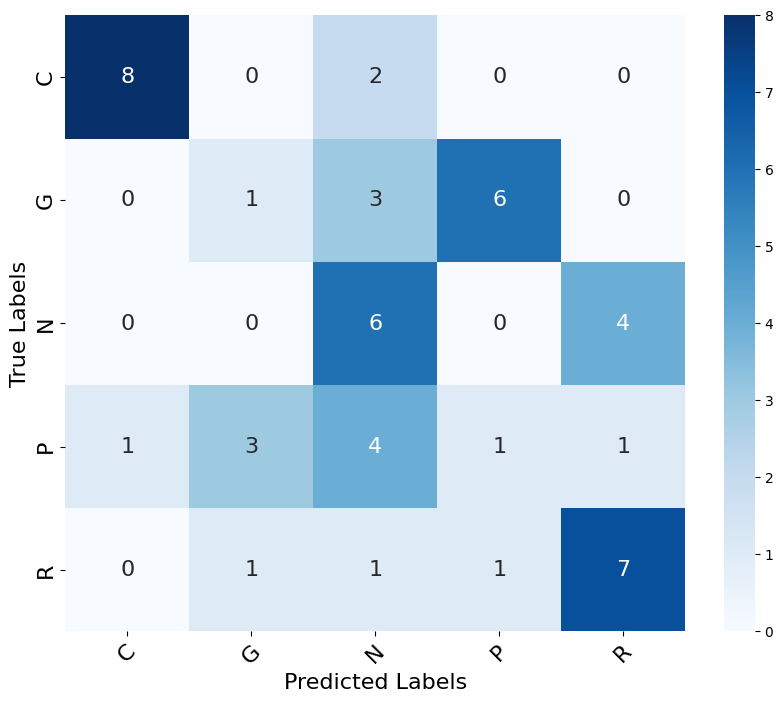

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(gold_labels, predicted_labels, labels=sorted(set(gold_labels + predicted_labels)))

# Plot confusion matrix
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(set(gold_labels + predicted_labels)),
    yticklabels=sorted(set(gold_labels + predicted_labels)),
    annot_kws={"size": 16}  # Increase font size of numbers inside the matrix
)

# Increase font size for axis labels and ticks
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.xticks(fontsize=16, rotation=45)  # Adjust rotation if needed
plt.yticks(fontsize=16)
# plt.title('Confusion Matrix', fontsize=18)
plt.show()
